In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

Precompiling LuxZygoteExt
        Info Given LuxZygoteExt was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? Lux → LuxZygoteExt
[ Info: Precompiling LuxZygoteExt [df13723f-0f22-5fb0-8a8f-885eac2ce1ee]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing LuxZygoteExt [df13723f-0f22-5fb0-8a8f-885eac2ce1ee].


In [3]:
using CUDA

In [4]:
using Statistics

In [5]:
n_x = 101
phases = range(-1.0, 1.0, n_x) |> collect;

In [6]:
import .PhasorNetworks: spike_current, phase_memory, neuron_constant

In [7]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [8]:
repeats = 6
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [9]:
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [10]:
st = phase_to_train(phases, spk_args=spk_args, repeats = repeats)

Spike Train: (101,) with 606 spikes.

In [11]:
sol = phase_memory(st, tspan=tspan, spk_args=spk_args);

In [12]:
u = Array(sol);

In [13]:
u |> size

(101, 602)

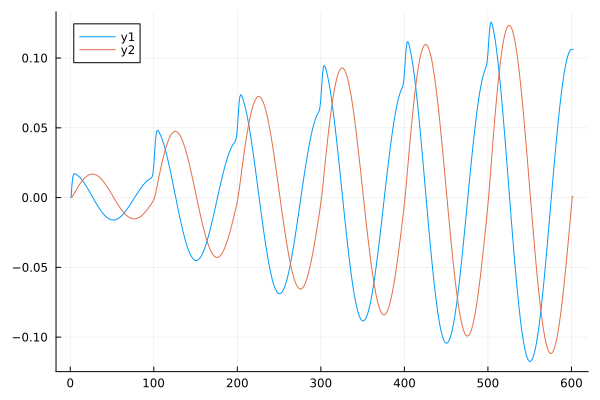

In [14]:
plot(real.(u[1,:]))
plot!(imag.(u[1,:]))

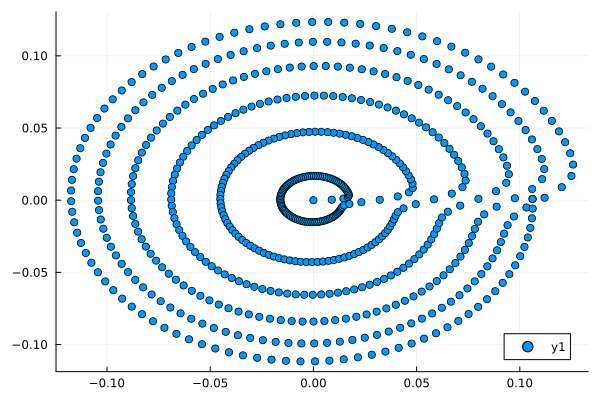

In [15]:
scatter(real.(u[1,:]), imag.(u[1,:]))

In [16]:
p = solution_to_phase(sol, spk_args=spk_args, final_t=false);

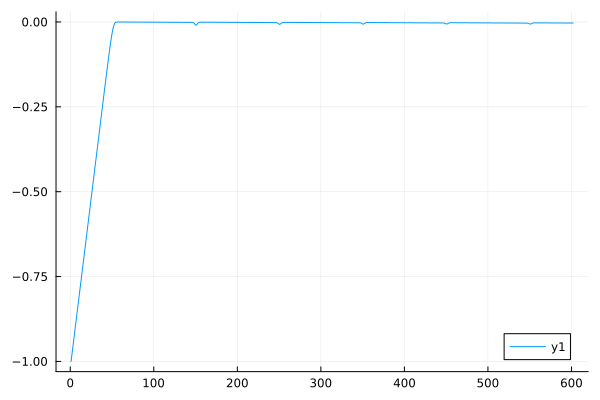

In [17]:
plot(p[51,:])

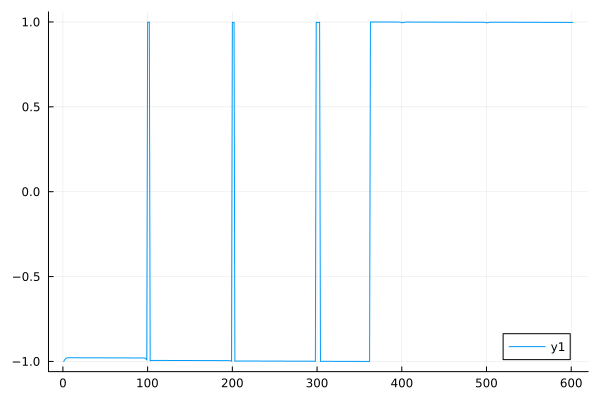

In [18]:
plot(p[1,:])

In [19]:
typeof(u)

Matrix{ComplexF32} (alias for Array{Complex{Float32}, 2})

In [20]:
st1 = solution_to_train(sol, tspan, spk_args = spk_args, offset=0.0)

Spike Train: (101,) with 606 spikes.

In [21]:
p1 = train_to_phase(st1, spk_args=spk_args)

6×101 Matrix{Float64}:
 0.997326  -0.982654  -0.962014  -0.941465  …  0.955291  0.968571  0.997326
 0.996732  -0.983247  -0.962607  -0.942058     0.956919  0.973878  0.996732
 0.996182  -0.983797  -0.963157  -0.942608     0.957058  0.974941  0.996182
 0.995674  -0.984305  -0.963665  -0.943116     0.95688   0.975171  0.995674
 0.995208  -0.984772  -0.964131  -0.943583     0.956602  0.975119  0.995208
 0.997503  -0.982832  -0.963308  -0.943606  …  0.956296  0.974951  0.997503

In [22]:
err2 = p1[end-1,:] .- phases;

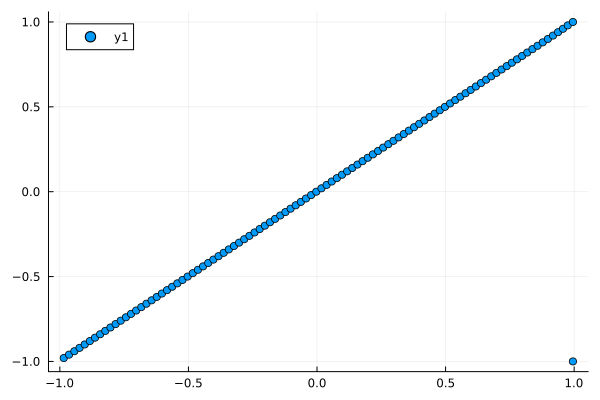

In [23]:
scatter(p1[end-1,:], phases)

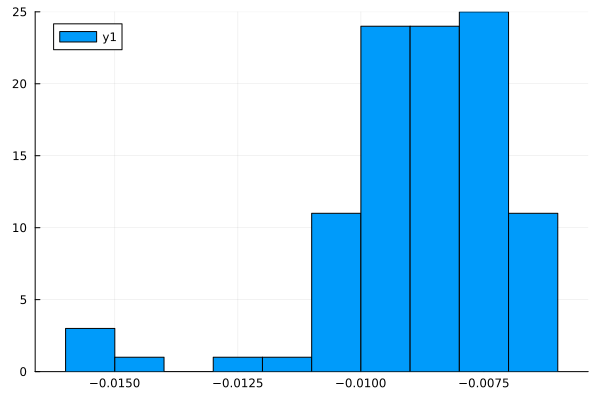

In [24]:
histogram(arc_error(err2))

In [25]:
stg = SpikeTrainGPU(st)

SpikeTrainGPU(CartesianIndex{1}[CartesianIndex(1,), CartesianIndex(2,), CartesianIndex(3,), CartesianIndex(4,), CartesianIndex(5,), CartesianIndex(6,), CartesianIndex(7,), CartesianIndex(8,), CartesianIndex(9,), CartesianIndex(10,)  …  CartesianIndex(92,), CartesianIndex(93,), CartesianIndex(94,), CartesianIndex(95,), CartesianIndex(96,), CartesianIndex(97,), CartesianIndex(98,), CartesianIndex(99,), CartesianIndex(100,), CartesianIndex(101,)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  597, 598, 599, 600, 601, 602, 603, 604, 605, 606], Float32[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 5.0], (101,), 101, 0.0)

In [26]:
using ChainRulesCore: ignore_derivatives

In [27]:
import .PhasorNetworks: gaussian_kernel

In [28]:
stg.indices

606-element CuArray{CartesianIndex{1}, 1, CUDA.DeviceMemory}:
 CartesianIndex(1,)
 CartesianIndex(2,)
 CartesianIndex(3,)
 CartesianIndex(4,)
 CartesianIndex(5,)
 CartesianIndex(6,)
 CartesianIndex(7,)
 CartesianIndex(8,)
 CartesianIndex(9,)
 CartesianIndex(10,)
 CartesianIndex(11,)
 CartesianIndex(12,)
 CartesianIndex(13,)
 ⋮
 CartesianIndex(90,)
 CartesianIndex(91,)
 CartesianIndex(92,)
 CartesianIndex(93,)
 CartesianIndex(94,)
 CartesianIndex(95,)
 CartesianIndex(96,)
 CartesianIndex(97,)
 CartesianIndex(98,)
 CartesianIndex(99,)
 CartesianIndex(100,)
 CartesianIndex(101,)

In [29]:
stg.linear_indices

606-element CuArray{Int64, 1, CUDA.DeviceMemory}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 595
 596
 597
 598
 599
 600
 601
 602
 603
 604
 605
 606

In [30]:
stg.shape

(101,)

In [31]:
stg.linear_shape

101

In [32]:
function scatter_add_kernel!(output, values, indices)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if i <= length(indices)
        index = indices[i]
        value = values[i]
        CUDA.@atomic output[index] += value
    end
    return nothing
end

function parallel_scatter_add(indices::CuArray{Int}, values::CuArray{T}, output_size::Int) where T
    @assert length(indices) == length(values) "Length of indices and values must match"
    
    output = CUDA.zeros(T, output_size)
    threads = 256
    blocks = cld(length(indices), threads)
    
    @cuda threads=threads blocks=blocks scatter_add_kernel!(output, values, indices)
    
    return output
end

parallel_scatter_add (generic function with 1 method)

In [33]:
# Set up sample data
n = 1_00
m = 100_000

# Create indices and values on the GPU
d_indices = rand(1:n, m) |> CuArray{Int}
d_values = CUDA.rand(Float32, m);

In [34]:
typeof(m)

Int64

In [35]:
d_indices

100000-element CuArray{Int64, 1, CUDA.DeviceMemory}:
 63
 24
 95
 27
 45
 22
 55
 99
 72
 33
 45
 85
 15
  ⋮
 31
 42
 86
 49
  4
  6
 74
 65
 70
 42
 53
 78

In [36]:
v = parallel_scatter_add(d_indices, d_values, n)

100-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 484.11865
 512.8409
 502.54248
 525.1197
 512.3117
 469.37457
 510.34894
 493.97415
 513.70996
 518.6316
 501.9418
 515.16943
 498.08533
   ⋮
 493.52676
 515.4109
 485.32553
 491.29886
 462.05762
 513.97504
 511.30994
 532.9651
 510.8693
 520.0769
 495.26535
 502.20584

In [37]:
for i in 1:1000 parallel_scatter_add(d_indices, d_values, n) end

In [38]:
for i in 1:10000 parallel_scatter_add(d_indices, d_values, n) end

In [39]:
#for i in 1:100000 parallel_scatter_add(d_indices, d_values, n) end

In [40]:
v

100-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 484.11865
 512.8409
 502.54248
 525.1197
 512.3117
 469.37457
 510.34894
 493.97415
 513.70996
 518.6316
 501.9418
 515.16943
 498.08533
   ⋮
 493.52676
 515.4109
 485.32553
 491.29886
 462.05762
 513.97504
 511.30994
 532.9651
 510.8693
 520.0769
 495.26535
 502.20584

In [41]:
function gaussian_kernel_gpu(x::Float32, t::Float32, t_sigma::Float32)
    i = exp(-1.0f0 * ((t - x) / (2.0f0 * t_sigma))^2.0f0)
    return i
end

gaussian_kernel_gpu (generic function with 1 method)

In [42]:
typeof(spk_args.t_window)

Float32

In [43]:
i0 = gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window))

606-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [44]:
for i in 1:1000 gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window)) end

In [45]:
for i in 1:10000 gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window)) end

In [46]:
function parallel_current(stg::SpikeTrainGPU, t::Float32, spk_args::SpikingArgs)
    currents = gaussian_kernel_gpu.(stg.times, t, Float32(spk_args.t_window))
    output = parallel_scatter_add(stg.linear_indices, currents, stg.linear_shape)
    
    return output
    
end

parallel_current (generic function with 1 method)

In [47]:
ik = parallel_current(stg, 0.1f0, spk_args)

101-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 1.3887945f-11
 1.6052218f-9
 1.12535176f-7
 4.7851177f-6
 0.00012340969
 0.0019304542
 0.01831562
 0.1053992
 0.36787927
 0.77880085
 1.0
 0.77880085
 0.3678796
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.3887945f-11

In [48]:
iv = stack([parallel_current(stg, t, spk_args) for t in 0.0f0:0.01f0:1.1f0])

101×111 CuArray{Float32, 2, CUDA.DeviceMemory}:
 1.0          0.778801     0.367879     …  0.0          0.0
 0.778801     1.0          0.778801        0.0          0.0
 0.367879     0.778801     1.0             0.0          0.0
 0.105399     0.367879     0.778801        0.0          0.0
 0.0183156    0.105399     0.367879        0.0          0.0
 0.00193045   0.0183156    0.105399     …  0.0          0.0
 0.00012341   0.00193045   0.0183156       0.0          0.0
 4.78512f-6   0.00012341   0.00193045      0.0          0.0
 1.12535f-7   4.78512f-6   0.00012341      0.0          0.0
 1.60522f-9   1.12535f-7   4.7851f-6       0.0          0.0
 1.38879f-11  1.60522f-9   1.12535f-7   …  0.0          0.0
 7.28772f-14  1.38879f-11  1.60522f-9      0.0          0.0
 2.31952f-16  7.28772f-14  1.38879f-11     0.0          0.0
 ⋮                                      ⋱               ⋮
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0          …  0.0        

In [49]:
iv2 = Array(iv);

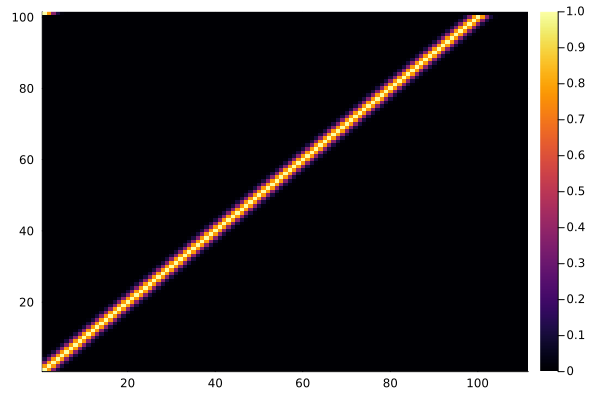

In [50]:
heatmap(iv2)

In [51]:
ival = spike_current(stg, 0.4f0, spk_args)

101-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

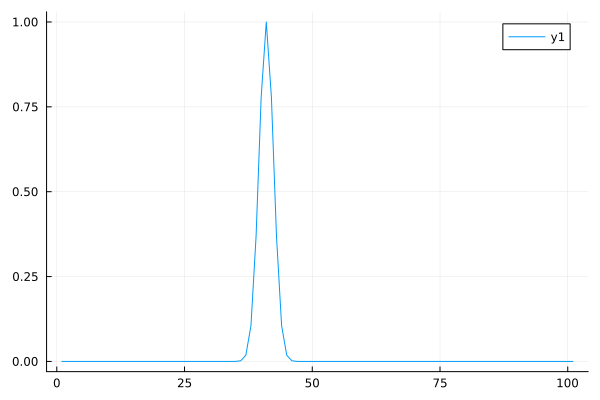

In [52]:
plot(Array(ival))

In [53]:
@time ivals = stack([Array(spike_current(stg, t, spk_args)) for t in 0.0f0:0.001f0:1.0f0], dims=1)

  0.165425 seconds (373.31 k allocations: 21.559 MiB, 76.37% compilation time)


1001×101 Matrix{Float32}:
 1.0       0.778801  0.367879  0.105399  …  0.0       0.0       1.0
 0.997503  0.816687  0.405555  0.122151     0.0       0.0       0.997503
 0.99005   0.852144  0.444858  0.140858     0.0       0.0       0.99005
 0.977751  0.884706  0.485537  0.161621     0.0       0.0       0.977751
 0.96079   0.913931  0.527292  0.18452      0.0       0.0       0.96079
 0.939413  0.939413  0.569783  0.209611  …  0.0       0.0       0.939413
 0.913931  0.96079   0.612626  0.236928     0.0       0.0       0.913931
 0.884706  0.977751  0.655406  0.266468     0.0       0.0       0.884706
 0.852144  0.99005   0.697676  0.298197     0.0       0.0       0.852144
 0.816687  0.997503  0.738968  0.33204      0.0       0.0       0.816687
 0.778801  1.0       0.778801  0.367879  …  0.0       0.0       0.778801
 0.738968  0.997503  0.816687  0.405555     0.0       0.0       0.738968
 0.697676  0.99005   0.852144  0.444858     0.0       0.0       0.697676
 ⋮                              

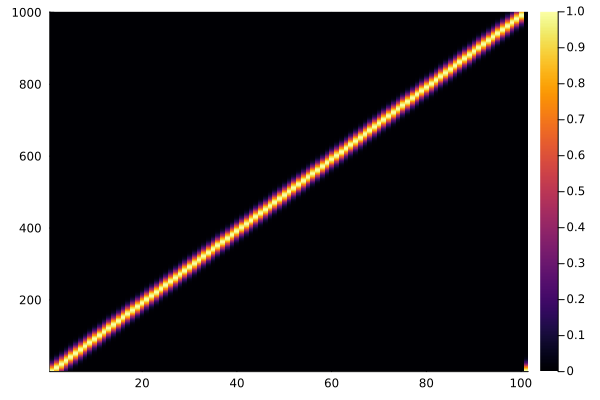

In [54]:
heatmap(ivals)

In [55]:
@time ivals2 = stack([Array(spike_current(st, t, spk_args)) for t in 0.0:0.001:1.0], dims=1);

  0.065956 seconds (139.42 k allocations: 14.255 MiB, 95.34% compilation time)


In [56]:
sum(abs2.(ivals .- ivals2))

31.03234f0

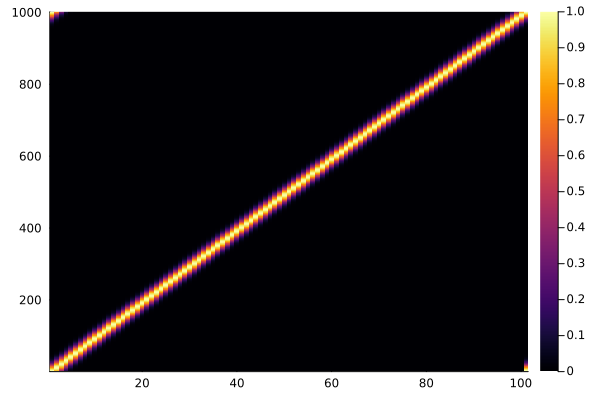

In [57]:
heatmap(ivals2)

In [58]:
spk_args

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [59]:
p1 = phase_memory(stg, spk_args=spk_args)

ODEProblem with uType CuArray{ComplexF32, 1, CUDA.DeviceMemory} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 101-element CuArray{ComplexF32, 1, CUDA.DeviceMemory}:
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
       ⋮
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im

In [60]:
sol1 = solve(p1, Tsit5(); spk_args.solver_args...)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 1002-element Vector{Float64}:
  0.0
  0.009999999776482582
  0.019999999552965164
  0.029999999329447746
  0.03999999910593033
  0.04999999888241291
  0.05999999865889549
  0.06999999843537807
  0.07999999821186066
  0.08999999798834324
  0.09999999776482582
  0.1099999975413084
  0.11999999731779099
  ⋮
  9.899999778717756
  9.909999778494239
  9.919999778270721
  9.929999778047204
  9.939999777823687
  9.94999977760017
  9.959999777376652
  9.969999777153134
  9.979999776929617
  9.9899997767061
  9.999999776482582
 10.0
u: 1002-element Vector{CuArray{ComplexF32, 1, CUDA.DeviceMemory}}:
 ComplexF32[0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im  …  0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0

In [61]:
ph1 = solution_to_phase(sol1, spk_args=spk_args)

101×1002 CuArray{Float64, 2, CUDA.DeviceMemory}:
 NaN   -0.990406   -0.983061   -0.979084  …  -0.977411  -0.977411  -0.977411
 NaN   -0.989587   -0.979988   -0.973173     -0.968407  -0.968407  -0.968407
 NaN   -0.988778   -0.976915   -0.966776     -0.955444  -0.955444  -0.955444
 NaN   -0.987998   -0.974092   -0.960872     -0.938722  -0.938722  -0.938722
 NaN  NaN          -0.971679   -0.956125     -0.919716  -0.919716  -0.919716
 NaN  NaN         NaN          -0.952624  …  -0.899898  -0.899898  -0.899898
 NaN  NaN         NaN         NaN            -0.879918  -0.879918  -0.879918
 NaN  NaN         NaN         NaN            -0.859919  -0.859919  -0.859919
 NaN  NaN         NaN         NaN            -0.839919  -0.839919  -0.839919
 NaN  NaN         NaN         NaN            -0.819919  -0.819919  -0.819919
 NaN  NaN         NaN         NaN         …  -0.799919  -0.799919  -0.799919
 NaN  NaN         NaN         NaN            -0.779919  -0.779919  -0.779919
 NaN  NaN         NaN      

In [62]:
ph1c = Array(ph1)

101×1002 Matrix{Float64}:
 NaN   -0.990406   -0.983061   -0.979084  …  -0.977411  -0.977411  -0.977411
 NaN   -0.989587   -0.979988   -0.973173     -0.968407  -0.968407  -0.968407
 NaN   -0.988778   -0.976915   -0.966776     -0.955444  -0.955444  -0.955444
 NaN   -0.987998   -0.974092   -0.960872     -0.938722  -0.938722  -0.938722
 NaN  NaN          -0.971679   -0.956125     -0.919716  -0.919716  -0.919716
 NaN  NaN         NaN          -0.952624  …  -0.899898  -0.899898  -0.899898
 NaN  NaN         NaN         NaN            -0.879918  -0.879918  -0.879918
 NaN  NaN         NaN         NaN            -0.859919  -0.859919  -0.859919
 NaN  NaN         NaN         NaN            -0.839919  -0.839919  -0.839919
 NaN  NaN         NaN         NaN            -0.819919  -0.819919  -0.819919
 NaN  NaN         NaN         NaN         …  -0.799919  -0.799919  -0.799919
 NaN  NaN         NaN         NaN            -0.779919  -0.779919  -0.779919
 NaN  NaN         NaN         NaN            -0.75

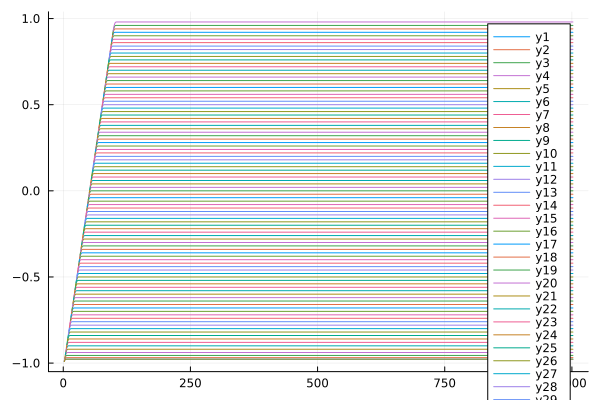

In [63]:
plot(ph1c')

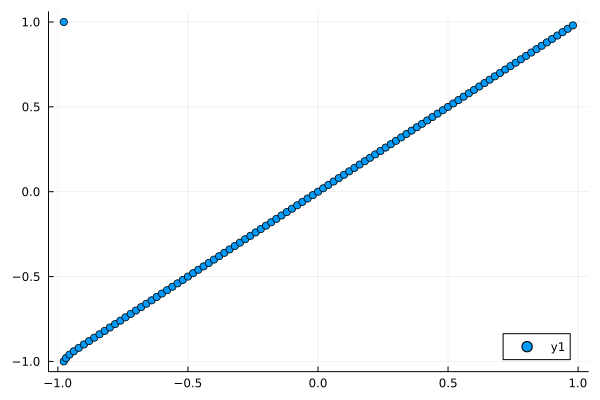

In [64]:
scatter(ph1c[:,end-1], phases)